# Merging a tile-scanned image in confocal onto a larger tif file

In [1]:
%matplotlib notebook
# Dependencies
import xml.etree.ElementTree as ET
import numpy as np
import glob
import cv2

from matplotlib import pyplot as plt

In [2]:
## Define a filename constructor for various identifiers

def getFileName(fname, zix, zstr, tix, tstr, six, sstr):
    fsplit_lst = fname.split("_")   # split filename by '_'
    # Rename the timepoint, z-scan and stagepos identifiers
    if zix is not None:
        fsplit_lst[zix] = zstr
    if tix is not None:
        fsplit_lst[tix] = tstr
    if six is not None:
        fsplit_lst[six] = sstr

    # Construct the full file name
    fname_ret = fsplit_lst[0]
    for fsplit in fsplit_lst[1:]:
        fname_ret += "_" + fsplit
    
    return fname_ret

## Read image properties from XML file

In [17]:
# Folder for the files
exp_name = "EQ59_01072021_12am"
# acq_name = "Interval12-36h_10pm"
acq_name = "First12h"

base_folder = f"D:/Tolga/Colony Images/{exp_name}/{acq_name}/"

# Replace the metadata_path with
metadata_path = base_folder + f"MetaData/{exp_name}_{acq_name}_Properties.xml"

tree = ET.parse(metadata_path)    # xml tree of the current stage position
root = tree.getroot()           # root of the xml tree

image = root[0]

In [18]:
# TileScan images are saved in parameter s**.
# Get the tilescan info
tilescan_info = None
for child in image:
    if child.get("Name") == "TileScanInfo":
        print("tilescan is set")
        tilescan_info = child
        break

tilescan is set


In [19]:
snum = len(tilescan_info)
xix_lst, yix_lst = [],[]     # x,y indices for each tile
xpos_lst, ypos_lst = [],[]    # x,y positions for each tile
# Run through each tile to take position information
for tile in tilescan_info:
    xix_lst.append(int(tile.get("FieldX")))
    yix_lst.append(int(tile.get("FieldY")))
    xpos_lst.append(np.double(tile.get("PosX")))
    ypos_lst.append(np.double(tile.get("PosY")))

# unique x,y indices for each tile
xix_unique_ar = np.unique(xix_lst)
yix_unique_ar = np.unique(yix_lst)

In [20]:
xix_unique_ar

array([0, 1, 2, 3, 4, 5, 6])

In [21]:
# Collect the image information for each
image_description = None
img_name = ""
xsz = ysz = zsz = ssz = tsz = -1
xvoxel = yvoxel = zvoxel = -1
for child in image:
    if child.tag == "ImageDescription":
        image_description = child
        for gchild in image_description:
            if gchild.tag == "Name":    # Name of the image
                img_name = gchild.text
            elif gchild.tag == "Dimensions":     # x,y,z,stage,t dimensions
                # Run through each deminson description
                for ggchild in gchild:
                    if ggchild.tag == "DimensionDescription":   # Check for tag
                        if ggchild.get("DimID") == "X":
                            xsz = int(ggchild.get("NumberOfElements"))
                            xvoxel = np.double(ggchild.get("Voxel"))
                        elif ggchild.get("DimID") == "Y":
                            ysz = int(ggchild.get("NumberOfElements"))
                            yvoxel = np.double(ggchild.get("Voxel"))
                        elif ggchild.get("DimID") == "Z":
                            zsz = int(ggchild.get("NumberOfElements"))
                            zvoxel = np.double(ggchild.get("Voxel"))
                        elif ggchild.get("DimID") == "Stage":
                            ssz = int(ggchild.get("NumberOfElements"))
                            svoxel = np.double(ggchild.get("Voxel"))
                        elif ggchild.get("DimID") == "T":
                            tsz = int(ggchild.get("NumberOfElements"))
                            # Note: tvoxel is not used!!
                            # Each image has its own timestamp data

In [22]:
# Block is defined by the x and y values of each edge
class Block:
    # __init__(self, left_top, right_bottom, width, height, xvoxel, yvoxel):
    def __init__(self, left_top, right_bottom, width, height, xvoxel, yvoxel):
        """
            @param left_top: The location of the left_top point
            @param right_bottom: The location of the right bottom
            @param width: Number of pixels in x
            @param height: Number of pixels in y
            @param xvoxel: width of each pixel in physical length
            @param yvoxel: height of each pixel in physical length
            
            left_top and right_bottom are calculated from the xml.properties file inside the Metadata folder
            The edges self.left, self.right, self.top and self.bottom defines the corresponding edges
            
            self.xidx and self.yidx are the indices that would correspond to the image
            
            Purpose of this class:
            The tilescan images have overlapping grids, so to merge all the grid-based tilescan images, 
            we need to redefine the block in the positions of each grid block
            
            How to use:
            First, we initialize each block with the overlapping coordinates. Then, consequentially, fix the overlapping
            coordinates by using the function overlap_fix(block). The parameter block here is an object of Block, which is near.
            The overlap_fix first checks where the overlap occurs with the block, then redefines the overlapping edge
            
            Note: The overlap_fix function consequentially assume overlapping blocks have the same non-overlapping position.
                Make sure to check this with the plot below.
        """
        # Edges
        self.left = left_top[0]
        self.right = right_bottom[0]
        self.top = left_top[1]
        self.bottom = right_bottom[1]
        
        # x,y pixel count
        self.width = width
        self.height = height
        # x and y pixel size in physical length
        self.xvoxel = xvoxel
        self.yvoxel = yvoxel
        # x,y pixel indices
        self.xidx = np.arange(self.width)
        self.yidx = np.arange(self.height)
        
    def is_inside_h(self, y):
        # Checks whether the y-coordinate is inside the horizontal range defined by the block
        if self.bottom < y and self.top > y:
            return True
        else:
            return False
    def is_inside_v(self, x):
        # Checks whether the x-coordinate is inside the vertical range defined by the block
        if self.left < x and self.right > x:
            return True
        else:
            return False
    def is_inside(self, x, y):
        """
            There must be a check for the microscope parameters flipx and swap-xy
            The function returns true if the given location is inside the block
            
        """
        print("Comparing x- (%g,%g) -- %g" % (left,right, x))
        print("Comparing y- (%g,%g) -- %g" % (bottom, top, y))
        if self.left < x and self.right > x and self.bottom < y and self.top > y: # inside the block
            return True
        else:
            return False
    def remove_left(self, right): # Remove the overlapping pixels up to right
        # The length of the overlap
        length = right - self.left
        print("x - Length = ", length)
#         self.left = right
        # Overlapping is removed
        self.xidx = np.arange(int(length/xvoxel), xsz)
        print("First x-index = ", self.xidx[0])
    def remove_bottom(self, top): # Remove the overlapping pixels up to top
        # The length of the overlap
        length = top - self.bottom
        print("y - Length = ", length)
#         selt.
        # Overlapping is removed
        self.yidx = np.arange(int(length/yvoxel), ysz)
        print("First y-index = ", self.yidx[0])
        
    def overlap_fix(self, block):
        # Overlap on the right --> Right of the self block is the left of the param block
        if self.is_inside_v(block.left):
            block.remove_left(self.right)
        if self.is_inside_h(block.bottom):
            block.remove_bottom(self.top)
        

In [24]:
# Copy all .tif file into a list
fname_list = glob.glob(base_folder+"TileScan/*.tif")
# For each file, collect string identifierse for t,s and z
tstr_st, sstr_st, zstr_st = set(),set(),set()
tstr_ix = 6     # timepoint identifier index
sstr_ix = 7     # stagepos identifier index
zstr_ix = 8    # z-scan identifier index

print("Did you check the tstr_ix, sstr_ix and zstr_ix??")
display(fname_list[0].split("_"))
display(fname_list[0].split("_")[zstr_ix])

Did you check the tstr_ix, sstr_ix and zstr_ix??


['D:/Tolga/Colony Images/EQ59',
 '01072021',
 '12am/First12h/TileScan\\EQ59',
 '01072021',
 '12am',
 'First12h',
 't00',
 's00',
 'z000',
 'ch00.tif']

'z000'

In [25]:
for fname in fname_list:
    fname_splt = fname.split("_")
    if tstr_ix is not None:
        tstr_st.add(fname_splt[tstr_ix])
    if sstr_ix is not None:
        sstr_st.add(fname_splt[sstr_ix])
    if zstr_ix is not None:
        zstr_st.add(fname_splt[zstr_ix])
    
# Sort the string identifiers and save as an array
tstr_ar = np.sort(list(tstr_st))
sstr_ar = np.sort(list(sstr_st))
zstr_ar = np.sort(list(zstr_st))

In [26]:
(ypos_lst[1] - ypos_lst[0])*1e6/yvoxel

920.7679485148518

In [27]:
# Define all the blocks and plot the edges
blocks_2d = np.empty((len(xix_unique_ar), len(yix_unique_ar)), dtype=Block)
for six in range(len(sstr_ar)):
    (x,y) = (xpos_lst[six]*1e6, ypos_lst[six]*1e6)   # convert to um
    # Define the square
    left = x-xvoxel*xsz/2
    right = x+xvoxel*xsz/2
    top = y+yvoxel*ysz/2
    bottom = y-yvoxel*ysz/2
    
    xix = xix_lst[six]
    yix = yix_lst[six]
    
    blocks_2d[xix, yix] = Block((left, top), (right, bottom), xsz, ysz, xvoxel, yvoxel)

<IPython.core.display.Javascript object>


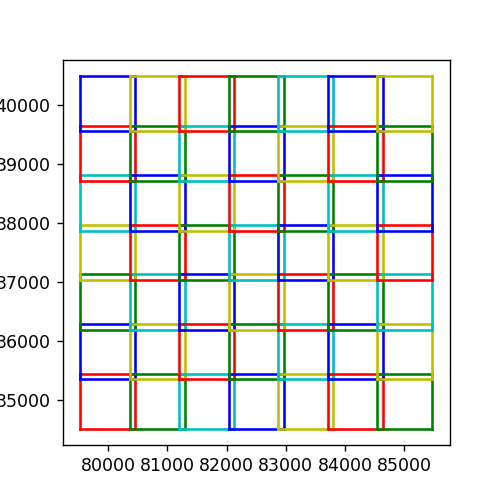

(79226.05466004, 85774.00749036, 34226.01258564, 40773.96541596)

In [28]:
# Before removing overlap
colors = ["r", "b", "g", "y", "c"]

fig, ax = plt.subplots(figsize=(4,4))
cix = 0
for block in blocks_2d.flatten():
    left = block.left
    right = block.right
    top = block.top
    bottom = block.bottom
    color = colors[cix%len(colors)]
    cix = cix+1

    ax.plot([left, right], [top, top], color)     # Top edge
    ax.plot([right, right], [top ,bottom], color)   # Right edge
    ax.plot([right, left], [bottom, bottom], color)   # Bottom edge
    ax.plot([left, left], [bottom, top], color)     # Left edge
    
ax.axis("equal")

In [29]:
for xix in xix_unique_ar[1:]:
    for yix in yix_unique_ar:
        # remove vertical overlap
        blocks_2d[xix, yix].remove_left(blocks_2d[xix-1,yix].right)
for yix in yix_unique_ar[1:]:
    for xix in xix_unique_ar:
        # remove horizontal overlap
        blocks_2d[xix, yix].remove_bottom(blocks_2d[xix,yix-1].top)
        

x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793479998712
First x-index =  103
x - Length =  93.83793480000168
First x-index =  103
x - Length =  93.83793480000168
First x-index =  103
x - Length =  93.83793480000168
First x-index =  103
x - Length =  93.83793480000168
First x-index =  103
x - Length =  93.83793480000168
First x-index 

<IPython.core.display.Javascript object>


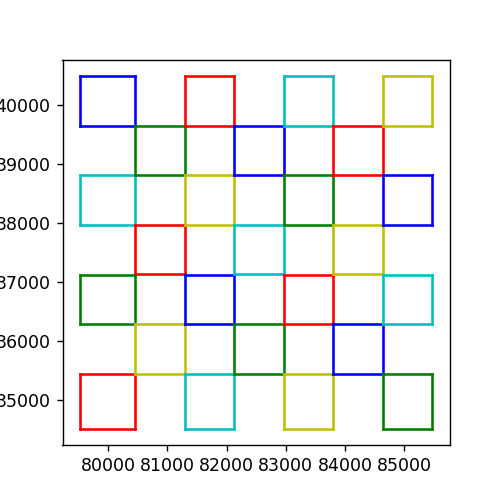

(79226.10011004, 85773.05304036001, 34226.058035639995, 40773.01096596)

In [30]:
# After removing overlap
colors = ["r", "b", "g", "y", "c"]

fig, ax = plt.subplots(figsize=(4,4))
cix = 0
for block in blocks_2d.flatten():
    if cix%2 == 0:
        left = block.left + block.xidx[0]*xvoxel
        right = block.left + block.xidx[-1]*xvoxel
        top = block.bottom + block.yidx[-1]*yvoxel
        bottom = block.bottom + block.yidx[0]*yvoxel
        color = colors[cix%len(colors)]

        ax.plot([left, right], [top, top], color)     # Top edge
        ax.plot([right, right], [top ,bottom], color)   # Right edge
        ax.plot([right, left], [bottom, bottom], color)   # Bottom edge
        ax.plot([left, left], [bottom, top], color)     # Left edge
    cix = cix+1

ax.axis("equal")
# ax.set_xlim(79000,87000)
# ax.set_ylim(36000,42000)

<IPython.core.display.Javascript object>


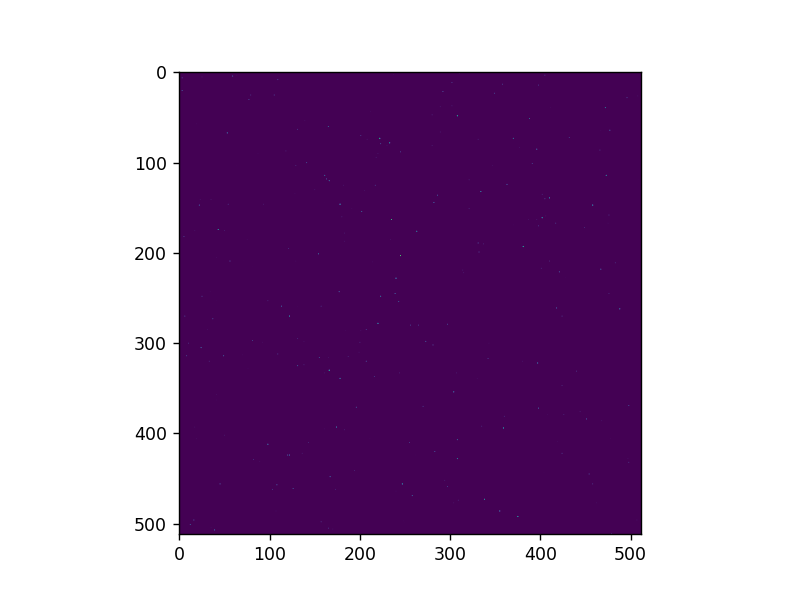

In [31]:
# Let's test merging a single timepoint for each z sections
# tstr = fname_list[-1].split("_")[tstr_ix]   # Last timepoint
# tstr_ar = ["t16"]
# zstr_ar = ["z160"]


# Run through all the tstr and zstr
fname_test = fname_list[0]
img_test = cv2.imread(fname_test, cv2.IMREAD_GRAYSCALE)
height, width = img_test.shape

# For each timepoint
for tix in range(len(tstr_ar)):
    tstr = tstr_ar[tix]
    # For each z section
    for zix in range(len(zstr_ar)):
        zstr = zstr_ar[zix]
        # File path to merge into
        if tstr is not None:
            fpath_merged = base_folder + "Merged/" + img_name + "_" + tstr + "_" + zstr + ".tif"
        else:
            fpath_merged = base_folder + "Merged/" + img_name + "_" + zstr + ".tif"

        # Create empty merged image
        img_merged_bw = np.zeros((height*len(yix_unique_ar), width*len(xix_unique_ar)), dtype=img_test.dtype)

        for six in range(len(sstr_ar)):    # Run over the stage positions -> single merged tif file
            sstr = sstr_ar[six]
            #Construct the filepath to merge
            fpath = getFileName(fname_list[0], zstr_ix, zstr, tstr_ix, tstr, sstr_ix, sstr)
            
            # x,y indices
            xix = xix_lst[six]
            yix = yix_lst[six]
            block = blocks_2d[xix,yix]
            
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
#             height,width = img.shape
            width = len(block.xidx)
            height = len(block.yidx)
            

            
            # Image pixel positions
            xixar = np.arange(0,width) + width*xix
            yixar = np.arange(0,height) + height*yix
            
            # SwapXY and FlipX
            flipped_img = np.transpose(np.flipud(img))
#####################################################################
#####################################################################
            img_merged_bw[(yix*height):((yix+1)*height), (xix*width):((xix+1)*width)] = \
                flipped_img[block.yidx[0]:(block.yidx[-1]+1), block.xidx[0]:(block.xidx[-1]+1)]

        print("Image merged for zstr = %s (%d/%d), tstr = %s (%d/%d)" % (zstr, zix, len(zstr_ar), 
                                                                         tstr, tix, len(tstr_ar)), 
              end="\r", flush=True)

        # Write the merged image
        cv2.imwrite(fpath_merged, img_merged_bw)
    
img_blur = cv2.GaussianBlur(img_merged_bw, (11,11),0)

# Add contrast for better visualization.
alpha = 20
beta = -10
img_contrast = np.uint8(np.clip(alpha*img_merged_bw + beta, 0, 255))
# Resize for video output
img_resized = cv2.resize(img_contrast, (512,512))

fig,ax = plt.subplots()

ax.imshow(img_resized)

In [ ]:
plt.imshow(img_resized)

In [ ]:
fname_list[-1].split("_")[tstr_ix]

In [ ]:
img_name

In [ ]:
fname_test

In [ ]:
img.max()